In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost

from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, linear_model, neighbors, naive_bayes, ensemble
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb

warnings.filterwarnings('ignore')

In [2]:
data_df = pd.read_csv("./data.csv")

In [3]:
data_df.head(5)

,No,Process\nRecipe,Time,Dose,Machine\nID,Trim\nFactor,Wafer\nsize,E.S.\nPressure\nComp,Estimated\ntime,B.L.\nPressure\nComp,...,Twist\nAngle\n(degrees),Estimated\nTime\n(HHMMSS),Actual Time\n(HHMMSS),Actual/\nEstimated\nTime,Interruptions,Beam\nHeight\n(mm),Gas Bottle 1\npres (kpa),Gas Bottle 2\npres (kpa),Gas Bottle 3\npres (kpa),Gas Bottle 4\npres (kpa)
0,1,P-30-60E15,0:22:38,6.00E+15,GSD263,1.056,200 mm,0.0,0:23:24,0,...,0,0:23:24,0:24:34,1.05,4,58,47.13,2560.68,5588.28,1433.7
1,2,P-30-60E15,0:54:54,6.00E+15,GSD263,1.056,200 mm,0.0,0:23:29,0,...,0,0:23:29,0:24:31,1.04,3,58,47.13,2561.66,5587.3,1434.43
2,3,P-30-60E15,1:25:04,6.00E+15,GSD263,1.056,200 mm,0.0,0:23:27,0,...,0,0:23:27,0:24:33,1.05,4,59,47.86,2561.91,5589.26,1436.14
3,4,BF-6-50E14,2:13:08,5.00E+14,GSD263,1.056,200 mm,0.0,0:07:55,0,...,0,0:07:55,0:12:00,1.52,0,77,47.13,2559.71,5585.1,1410.5
4,5,BF-6-50E14,2:29:30,5.00E+14,GSD263,1.056,200 mm,0.0,0:07:07,0,...,0,0:07:07,0:11:15,1.58,0,78,46.89,2561.91,5581.44,1412.45


In [4]:
data_df = data_df.drop("Machine\nID", axis=1)
data_df = data_df.drop("Beamguide\nGas", axis=1)
data_df = data_df.drop("Source\nInjection\nGas", axis=1)

In [5]:
data_df.columns

Index(['No', 'Process\nRecipe', 'Time', 'Dose ', 'Trim\nFactor', 'Wafer\nsize',
       'E.S.\nPressure\nComp', 'Estimated\ntime ', 'B.L.\nPressure\nComp',
       'Actual\ntime', 'Implant\nStart Prs', 'Interruptions  ',
       'Implant\nStop Prs', 'Implant\nMin. Prs', 'Ion\ncharge', 'Tilt\nangle ',
       'Twist\nangle', 'Snapshot\ncount', 'Beam\nHeight', 'Material\nI.D_1',
       'Material\nI.D_2', 'Total\nenergy\n(keV)', 'AMU', 'target',
       'Preset\nScans', 'Source\nPressure\n(Torr)',
       'Beamline\nPressure\n(Torr)', 'Chamber\nPressure\n(Torr)',
       'Arc\nCurrent\n(Amps)', 'Arc\nVoltage\n(Volts)',
       'Filament\nCurrent\n(Amps)', 'Cathode\nVoltage\n(Volts)',
       'Cathode\nCurrent\n(Amps)', 'Extraction\nCurrent\n(mA)',
       'Extraction\nVoltage\n(kV)', 'Vap #1\nOven Temp\n(DegC)',
       'Vap #1\nHeater Temp\n(DegC)', 'Vap #2\nOven Temp\n(DegC)',
       'Vap #2\nHeater Temp\n(DegC)', 'Gas #1\nMFC\n(sccm)',
       'Gas #2\nMFC\n(sccm)', 'Gas #3\nMFC\n(sccm)', 'Gas #4\

In [6]:
clean_index_list = [index.replace('\n', ' ') for index in data_df.columns]
data_df.columns = clean_index_list

data_df

,No,Process Recipe,Time,Dose,Trim Factor,Wafer size,E.S. Pressure Comp,Estimated time,B.L. Pressure Comp,Actual time,...,Twist Angle (degrees),Estimated Time (HHMMSS),Actual Time (HHMMSS),Actual/ Estimated Time,Interruptions,Beam Height (mm),Gas Bottle 1 pres (kpa),Gas Bottle 2 pres (kpa),Gas Bottle 3 pres (kpa),Gas Bottle 4 pres (kpa)
0,1,P-30-60E15,0:22:38,6.00E+15,1.056,200 mm,0.0,0:23:24,0,0:24:35,...,0,0:23:24,0:24:34,1.05,4,58,47.13,2560.68,5588.28,1433.7
1,2,P-30-60E15,0:54:54,6.00E+15,1.056,200 mm,0.0,0:23:29,0,0:24:32,...,0,0:23:29,0:24:31,1.04,3,58,47.13,2561.66,5587.3,1434.43
2,3,P-30-60E15,1:25:04,6.00E+15,1.056,200 mm,0.0,0:23:27,0,0:24:34,...,0,0:23:27,0:24:33,1.05,4,59,47.86,2561.91,5589.26,1436.14
3,4,BF-6-50E14,2:13:08,5.00E+14,1.056,200 mm,0.0,0:07:55,0,0:12:02,...,0,0:07:55,0:12:00,1.52,0,77,47.13,2559.71,5585.1,1410.5
4,5,BF-6-50E14,2:29:30,5.00E+14,1.056,200 mm,0.0,0:07:07,0,0:11:17,...,0,0:07:07,0:11:15,1.58,0,78,46.89,2561.91,5581.44,1412.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065,3066,P-30-60E15,21:46:26,6.00E+15,1.056,200 mm,0.0,0:23:51,0,0.017673611,...,0,0.0165625,0.017662037,1.07,1,58,31.5,1905.49,3437.12,5632.23
3066,3067,P-30-60E15,22:16:20,6.00E+15,1.056,200 mm,0.0,0:24:32,0,0.017939815,...,0,0.017037037,0.017928241,1.05,2,58,31.01,1905.49,3440.29,5631.01
3067,3068,P-30-60E15,22:47:33,6.00E+15,1.056,200 mm,0.0,0:24:23,0,0.018368056,...,0,0.01693287,0.018356481,1.08,5,62,31.5,1905.01,3439.32,5630.28
3068,3069,P-30-60E15,23:19:04,6.00E+15,1.056,200 mm,0.0,0:24:25,0,0.01818287,...,0,0.016956019,0.018171296,1.07,4,60,32.23,1903.05,3441.03,5628.57


In [7]:
for index in clean_index_list:
    if data_df[index].isna().sum() != 0:
        print(index)

Material I.D_2


In [8]:
data_df = data_df.drop("Material I.D_2", axis=1)
data_df = data_df.drop("No", axis=1)
data_df = data_df.drop("Estimated Time (HHMMSS)", axis=1)
data_df = data_df.drop("Actual Time (HHMMSS)", axis=1)

In [9]:
data_df = data_df[~data_df.apply(lambda row: row.astype(str).str.contains('abort')).any(axis=1)]

# 결과 출력
data_df.head(5)

,Process Recipe,Time,Dose,Trim Factor,Wafer size,E.S. Pressure Comp,Estimated time,B.L. Pressure Comp,Actual time,Implant Start Prs,...,Charge Mon Neg Peak(volts),Tilt Angle (degrees),Twist Angle (degrees),Actual/ Estimated Time,Interruptions,Beam Height (mm),Gas Bottle 1 pres (kpa),Gas Bottle 2 pres (kpa),Gas Bottle 3 pres (kpa),Gas Bottle 4 pres (kpa)
0,P-30-60E15,0:22:38,6.00E+15,1.056,200 mm,0.0,0:23:24,0,0:24:35,0.00005,...,11.5,0,0,1.05,4,58,47.13,2560.68,5588.28,1433.7
1,P-30-60E15,0:54:54,6.00E+15,1.056,200 mm,0.0,0:23:29,0,0:24:32,0.00005,...,11.7,0,0,1.04,3,58,47.13,2561.66,5587.3,1434.43
2,P-30-60E15,1:25:04,6.00E+15,1.056,200 mm,0.0,0:23:27,0,0:24:34,0.00005,...,12.4,0,0,1.05,4,59,47.86,2561.91,5589.26,1436.14
3,BF-6-50E14,2:13:08,5.00E+14,1.056,200 mm,0.0,0:07:55,0,0:12:02,0.00005,...,20,0,0,1.52,0,77,47.13,2559.71,5585.1,1410.5
4,BF-6-50E14,2:29:30,5.00E+14,1.056,200 mm,0.0,0:07:07,0,0:11:17,0.00005,...,19.5,0,0,1.58,0,78,46.89,2561.91,5581.44,1412.45


In [10]:
for index in data_df.columns:
    print(data_df[index].value_counts())

P-60-10E14     286
AS-50-70E15    280
P-30-60E15     240
BF-25-40E15    209
AS-40-70E15    164
              ... 
BF-10-37E14      1
BF-60-20E13      1
BF-45-60E13      1
BF-45-20E13      1
BF-20-10E15      1
Name: Process Recipe, Length: 69, dtype: int64
10:25:34    3
17:43:51    3
3:10:23     2
15:08:26    2
13:11:52    2
           ..
18:06:02    1
18:42:27    1
19:25:06    1
20:01:45    1
23:50:35    1
Name: Time, Length: 3008, dtype: int64
1.00E+14         524
7.00E+15         444
5.00E+15         349
6.00E+14         265
4.00E+15         248
6.00E+15         240
3.00E+13         218
2.00E+15         143
2.00E+14         122
5.40E+14         103
2.00E+13          91
6.50E+14          81
3.00E+14          56
2.50E+14          33
3.40E+15          24
1.50E+14          19
3.50E+13          16
4.00E+14          12
1.20E+14           9
5.50E+15           6
4.30E+15           6
4.60E+15           6
7.00E+14           5
4.00E+13           5
4.50E+15           5
3.50E+15           4
5.00E

In [11]:
data_df.reset_index(drop=True, inplace=True)

In [12]:
data_df = data_df.drop("Wafer size", axis=1)
data_df = data_df.drop("Dose ", axis=1)
data_df = data_df.drop("E.S. Pressure Comp", axis=1)
data_df = data_df.drop("B.L. Pressure Comp", axis=1)
data_df = data_df.drop("Implant Min. Prs", axis=1)
data_df = data_df.drop("Ion charge", axis=1)
data_df = data_df.drop("Tilt angle ", axis=1)
data_df = data_df.drop("Twist angle", axis=1)
data_df = data_df.drop("Snapshot count", axis=1)
data_df = data_df.drop("Tilt Angle (degrees)", axis=1)
data_df = data_df.drop("Twist Angle (degrees)", axis=1)
data_df = data_df.drop("El.Sh. Bias Voltage(kV)", axis=1)
data_df = data_df.drop("El.Sh. MFC Gas Flow(sccm)", axis=1)

In [13]:
time_columns = [col for col in data_df.columns if "time" in col.lower()]

for time_col in time_columns:
    for i in range(len(data_df[time_col])):
        if ":" in data_df[time_col][i]:
            h, m, s = data_df[time_col][i].split(":")
            data_df[time_col][i] = np.round((3600 * int(h) + 60 * int(m) + int(s))/60, 3)
            
    data_df[time_col] = data_df[time_col].astype(np.float64)

In [14]:
data_df.head(3)

,Process Recipe,Time,Trim Factor,Estimated time,Actual time,Implant Start Prs,Interruptions,Implant Stop Prs,Beam Height,Material I.D_1,...,Disk Current (mA),Charge Mon Pos Peak(volts),Charge Mon Neg Peak(volts),Actual/ Estimated Time,Interruptions,Beam Height (mm),Gas Bottle 1 pres (kpa),Gas Bottle 2 pres (kpa),Gas Bottle 3 pres (kpa),Gas Bottle 4 pres (kpa)
0,P-30-60E15,22.633,1.056,23.400,24.583,0.00005,4,0.00012,58,CW03392,...,0.2,6,11.5,1.05,4,58,47.13,2560.68,5588.28,1433.7
1,P-30-60E15,54.900,1.056,23.483,24.533,0.00005,3,0.00012,59,CW03389,...,0.2,5.2,11.7,1.04,3,58,47.13,2561.66,5587.3,1434.43
2,P-30-60E15,85.067,1.056,23.450,24.567,0.00005,4,0.00012,60,CW03389,...,0.4,6.1,12.4,1.05,4,59,47.86,2561.91,5589.26,1436.14


In [15]:
for index in data_df.columns:
    try:
        data_df[index] = data_df[index].astype(np.float64)
    
    except Exception as e:
        print(e)

could not convert string to float: 'P-30-60E15'
could not convert string to float: 'CW03392'


In [16]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Process Recipe              3062 non-null   object 
 1   Time                        3062 non-null   float64
 2   Trim Factor                 3062 non-null   float64
 3   Estimated time              3062 non-null   float64
 4   Actual time                 3062 non-null   float64
 5   Implant Start Prs           3062 non-null   float64
 6   Interruptions               3062 non-null   float64
 7   Implant Stop Prs            3062 non-null   float64
 8   Beam Height                 3062 non-null   float64
 9   Material I.D_1              3062 non-null   object 
 10  Total energy (keV)          3062 non-null   float64
 11  AMU                         3062 non-null   float64
 12  target                      3062 non-null   float64
 13  Preset Scans                3062 

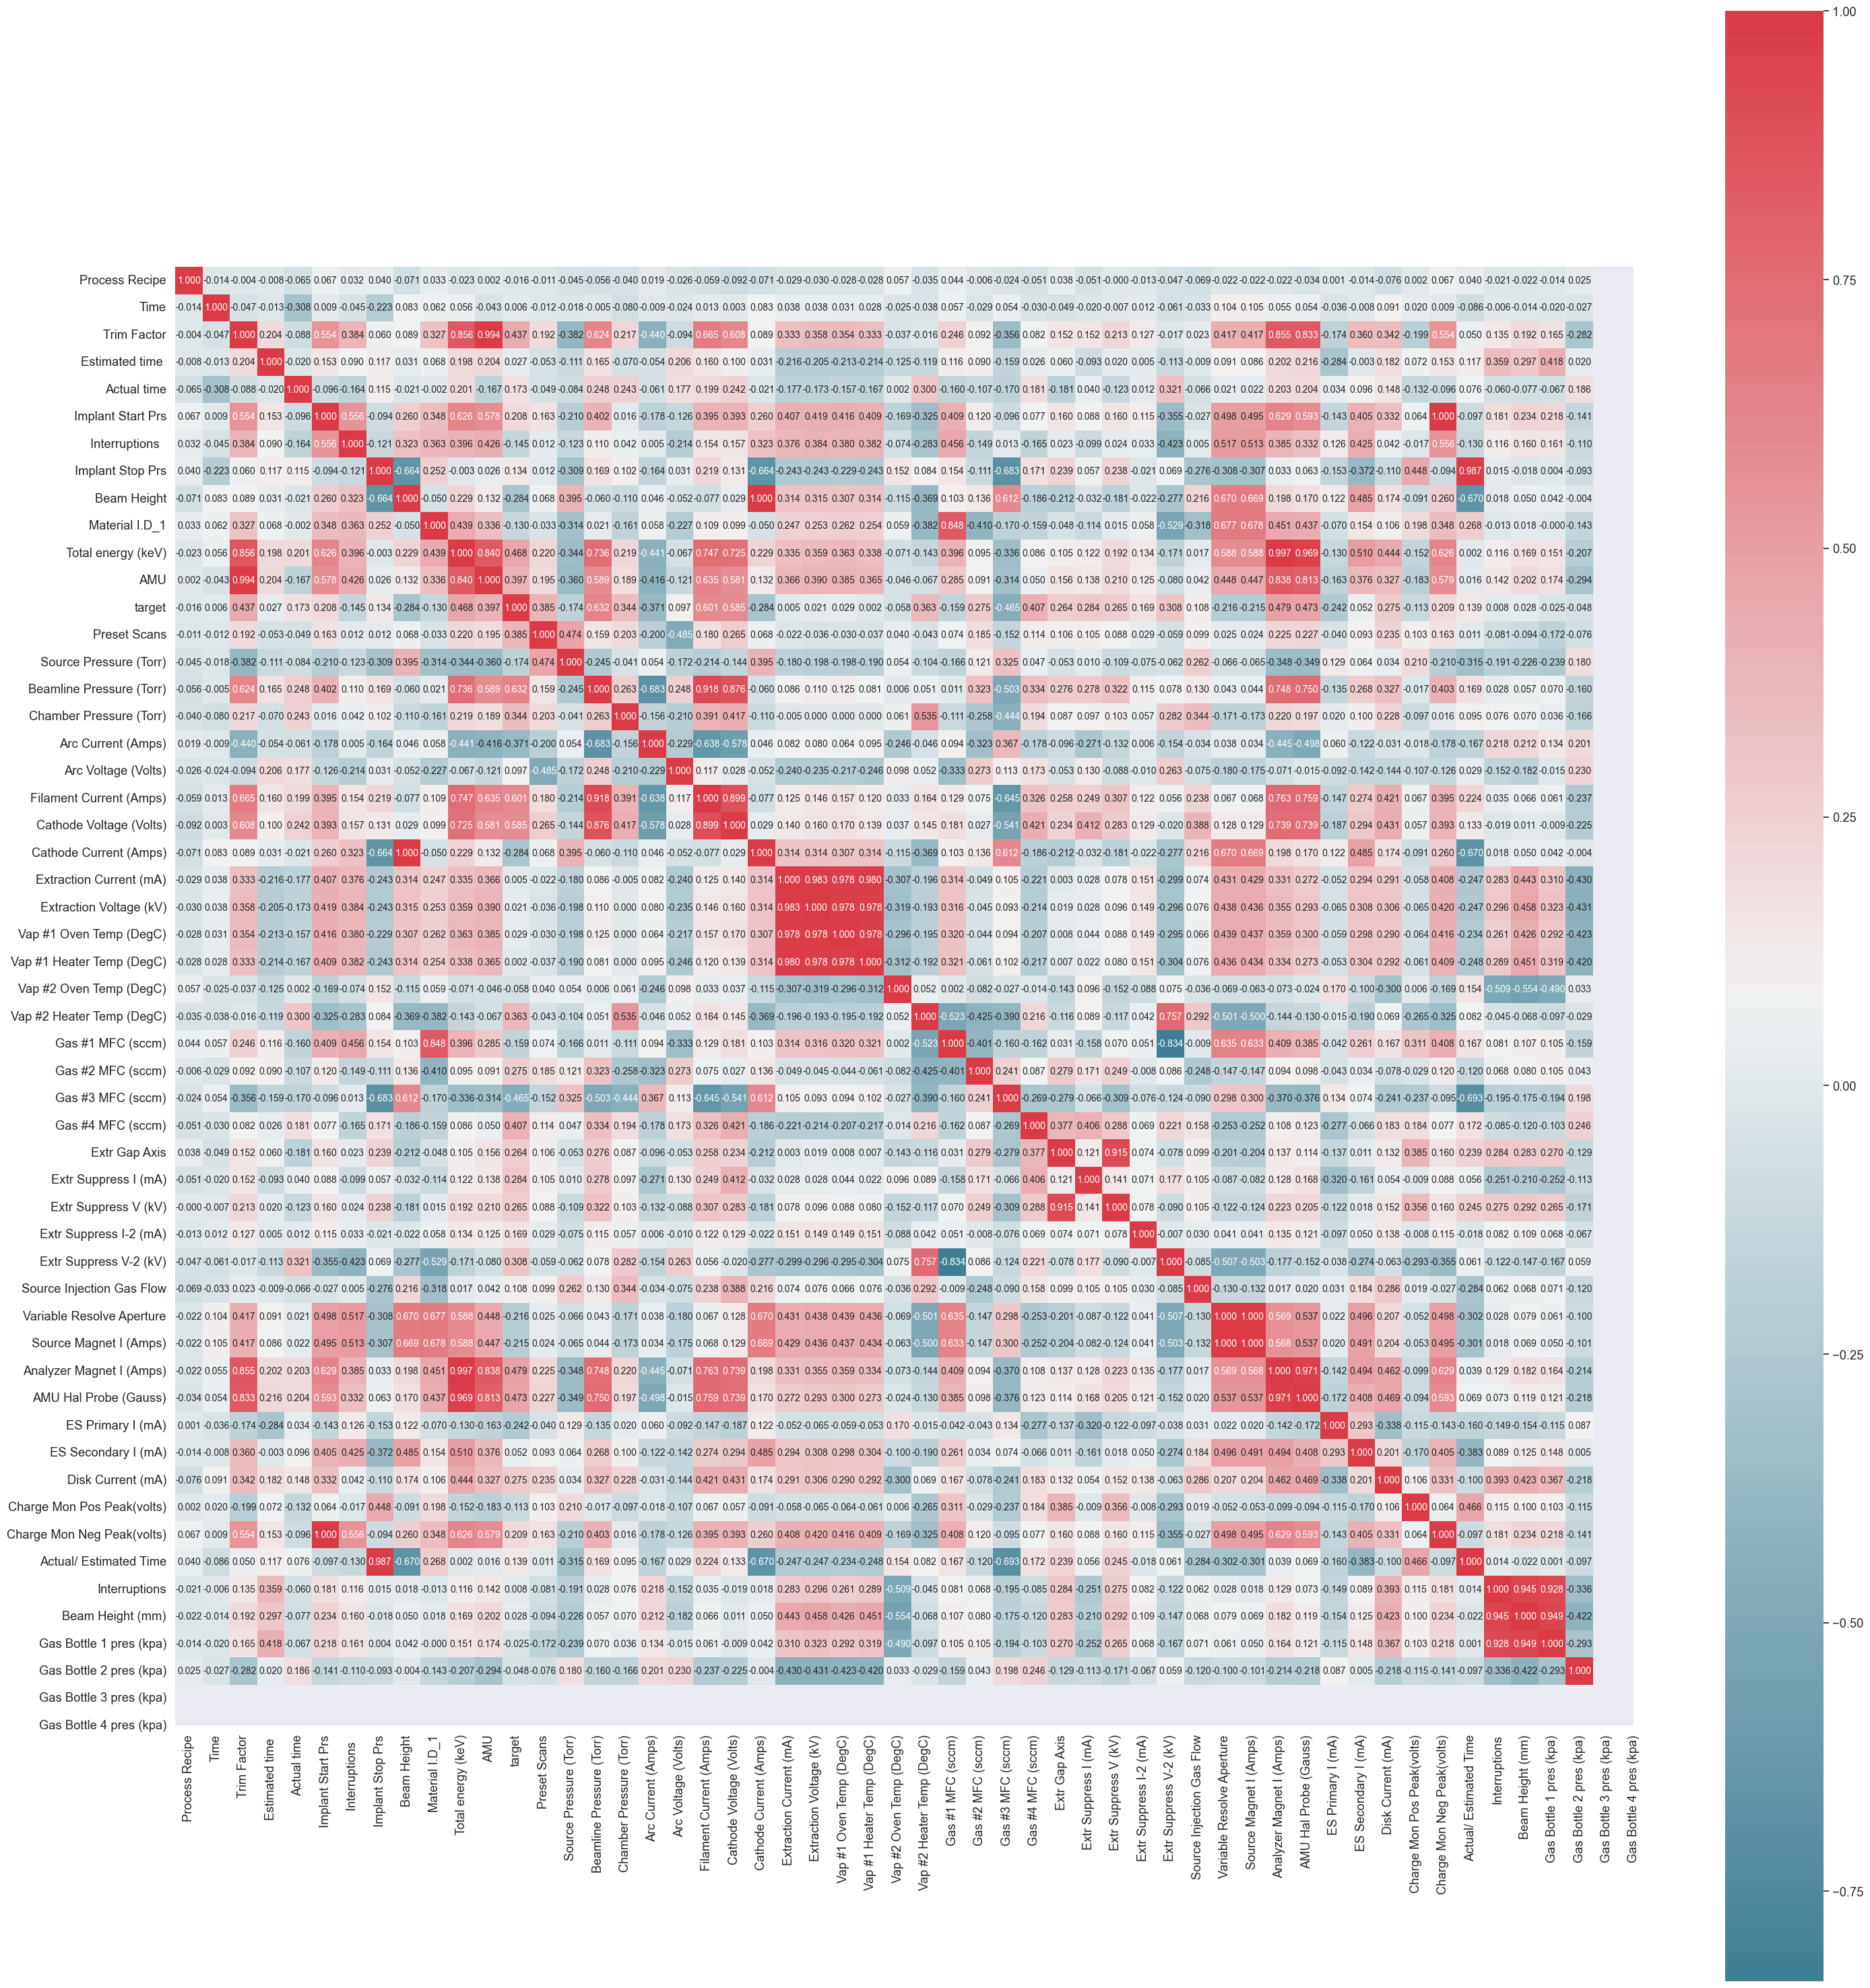

In [17]:
corr_column_names = list(data_df.columns)
corr = data_df.corr(method = 'pearson')
colormap = sns.diverging_palette(220, 10, as_cmap = True)

sns.set(font_scale = 1.2, rc = {'figure.figsize' : (30, 30)})
dis_df_heatmap = sns.heatmap(corr.values,
                             cmap = colormap,
                             cbar = True,
                             annot = True,
                             annot_kws = {'size' : 10},
                             fmt = '.3f',
                             square = 'True',
                             yticklabels = corr_column_names,
                             xticklabels = corr_column_names)
plt.tight_layout()
plt.show()

In [18]:
target_df = data_df['target']
train_df = data_df.drop('target', axis=1)

In [19]:
target_df

0       0.004970
1       0.004960
2       0.004990
3       0.000914
4       0.000965
          ...   
3057    0.004690
3058    0.004650
3059    0.004650
3060    0.004680
3061    0.004890
Name: target, Length: 3062, dtype: float64

In [20]:
St_scaler = StandardScaler()
label_encoder = LabelEncoder()
train_df['Process Recipe'] = train_df['Process Recipe'].astype(str)
train_df['Material I.D_1'] = train_df['Material I.D_1'].astype(str)

train_df.iloc[:, 1:9] = St_scaler.fit_transform(train_df.iloc[:, 1:9])
train_df.iloc[:, 11:] = St_scaler.fit_transform(train_df.iloc[:, 11:])

train_df['Process Recipe'] = label_encoder.fit_transform(train_df['Process Recipe'].values.reshape(-1, 1)).astype(np.float64)
train_df['Material I.D_1'] = label_encoder.fit_transform(train_df['Material I.D_1'].values.reshape(-1, 1)).astype(np.float64)

In [21]:
train_df.head(3)

,Process Recipe,Time,Trim Factor,Estimated time,Actual time,Implant Start Prs,Interruptions,Implant Stop Prs,Beam Height,Material I.D_1,...,Disk Current (mA),Charge Mon Pos Peak(volts),Charge Mon Neg Peak(volts),Actual/ Estimated Time,Interruptions,Beam Height (mm),Gas Bottle 1 pres (kpa),Gas Bottle 2 pres (kpa),Gas Bottle 3 pres (kpa),Gas Bottle 4 pres (kpa)
0,62.0,-1.696510,-0.051181,1.110801,4.334785,-0.187488,0.216974,-0.256785,0.438435,40.0,...,-1.584318,-0.581055,-0.238846,-0.288929,0.217129,0.467895,1.798693,1.298114,1.872306,0.138199
1,62.0,-1.616875,-0.051181,1.119458,4.325449,-0.187488,0.015526,-0.256785,0.521244,38.0,...,-1.584318,-0.756760,-0.199334,-0.384779,0.015660,0.467895,1.798693,1.302593,1.870829,0.138640
2,62.0,-1.542422,-0.051181,1.116016,4.331798,-0.187488,0.216974,-0.256785,0.604052,38.0,...,-0.842660,-0.559092,-0.061042,-0.288929,0.217129,0.552816,1.955311,1.303736,1.873784,0.139673


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Process Recipe              3062 non-null   float64
 1   Time                        3062 non-null   float64
 2   Trim Factor                 3062 non-null   float64
 3   Estimated time              3062 non-null   float64
 4   Actual time                 3062 non-null   float64
 5   Implant Start Prs           3062 non-null   float64
 6   Interruptions               3062 non-null   float64
 7   Implant Stop Prs            3062 non-null   float64
 8   Beam Height                 3062 non-null   float64
 9   Material I.D_1              3062 non-null   float64
 10  Total energy (keV)          3062 non-null   float64
 11  AMU                         3062 non-null   float64
 12  Preset Scans                3062 non-null   float64
 13  Source Pressure (Torr)      3062 

In [23]:
train_df.isna().sum().sum()

0

In [24]:
target_df.isna().sum()

0

In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df, target_df ,test_size=0.25, random_state=42)

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2296, 53) (766, 53) (2296,) (766,)


In [27]:
xgb_model = xgboost.XGBRegressor(n_estimators=2000, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1.0, max_depth=3)

In [28]:
# reg_cv = model_selection.GridSearchCV(xgb_model, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
#                             ,'max_depth': [3,4,6,7,8,9,10], 'n_estimators': [500,1000,1500,2000,2500]}, verbose=1)
# reg_cv.fit(X_train,y_train)

# reg_cv.best_params_

In [29]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

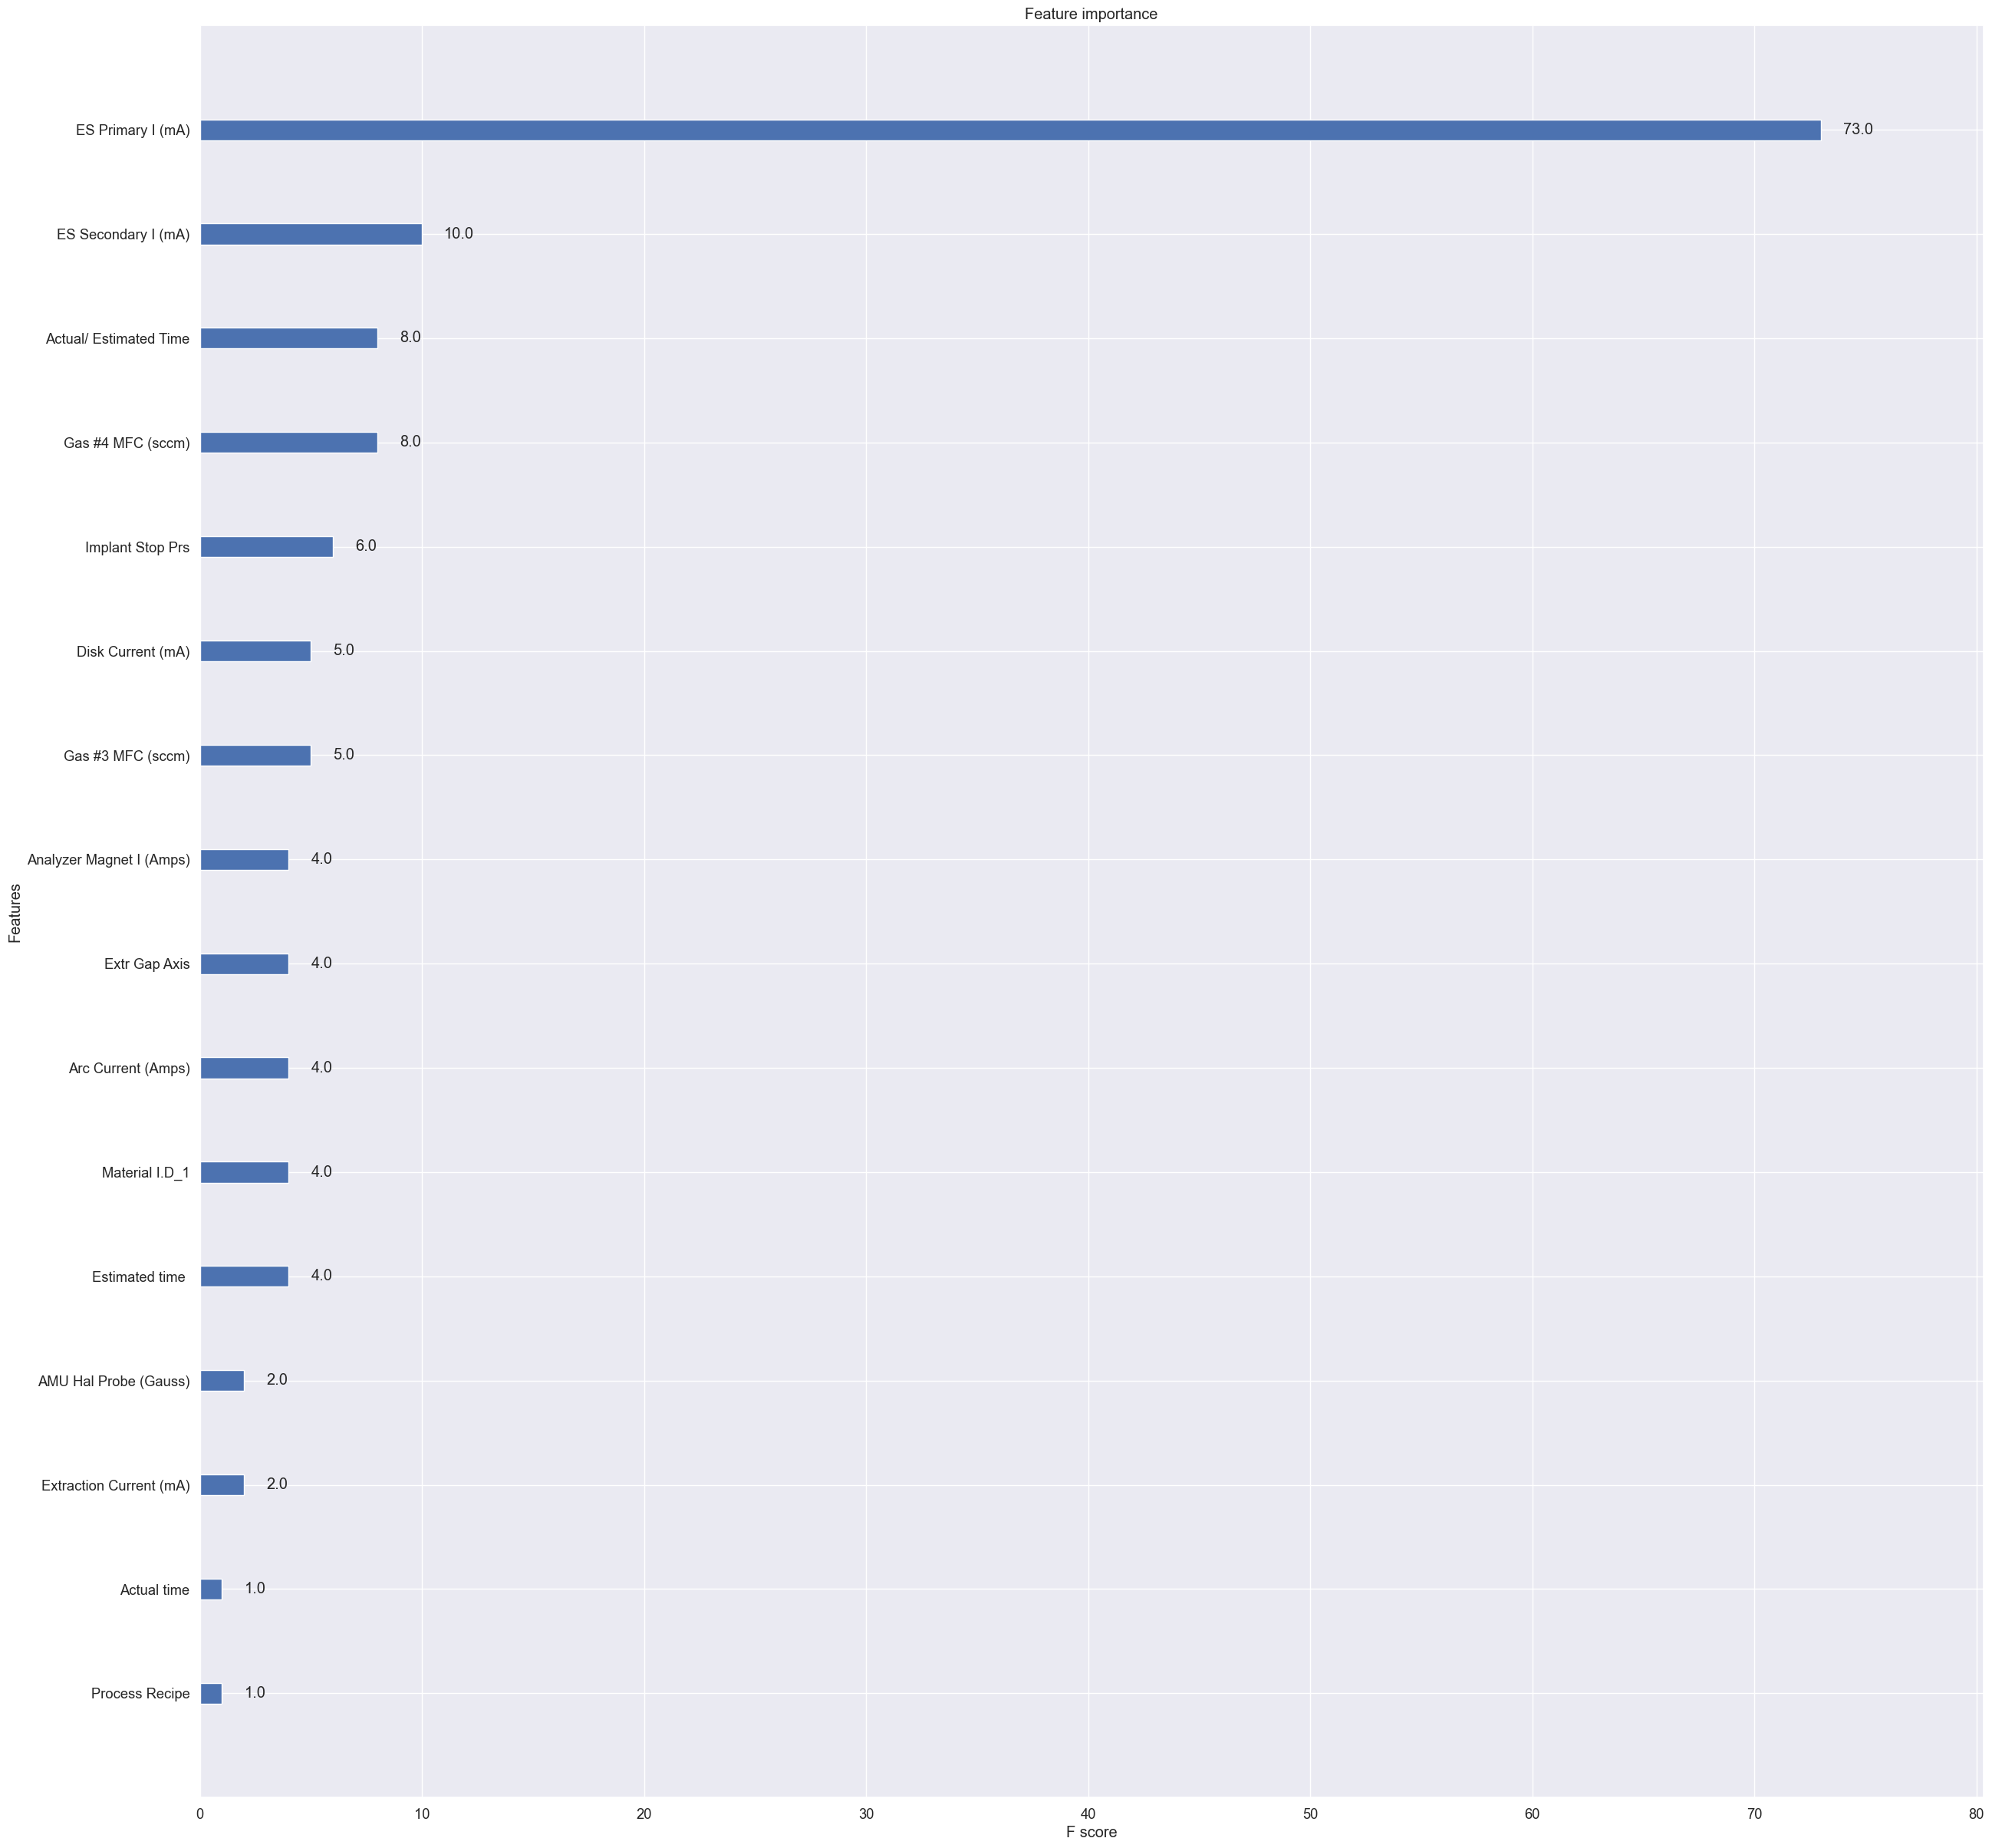

In [30]:
xgboost.plot_importance(xgb_model)

In [31]:
predictions = xgb_model.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.000102


In [32]:
r_sq = xgb_model.score(X_train, y_train)

print(r_sq)
print(metrics.explained_variance_score(predictions,y_test))

0.9975876779590694
0.9973069812598412


In [33]:
X_test.iloc[:][5:6]

,Process Recipe,Time,Trim Factor,Estimated time,Actual time,Implant Start Prs,Interruptions,Implant Stop Prs,Beam Height,Material I.D_1,...,Disk Current (mA),Charge Mon Pos Peak(volts),Charge Mon Neg Peak(volts),Actual/ Estimated Time,Interruptions,Beam Height (mm),Gas Bottle 1 pres (kpa),Gas Bottle 2 pres (kpa),Gas Bottle 3 pres (kpa),Gas Bottle 4 pres (kpa)
102,34.0,1.282421,-0.051181,-0.883144,0.753072,-0.187488,-0.588816,-0.433516,1.100902,287.0,...,-0.471832,-0.888539,0.748952,1.723932,-0.588748,1.232181,1.747203,1.186508,1.742318,0.100415


In [34]:
y_test.iloc[:][5:6]

102    0.000784
Name: target, dtype: float64

In [35]:
pred = xgb_model.predict(X_test.iloc[:][5:6])

In [36]:
rmse = np.sqrt(metrics.mean_squared_error(y_test.iloc[:][5:6], pred))

print(rmse)

0.00012608329764008525


In [37]:
pred = xgb_model.predict(X_test.iloc[:][10:20])

pred

array([0.0013833 , 0.00476245, 0.00527202, 0.00484049, 0.00091008,
       0.00091943, 0.00091943, 0.00093202, 0.0016194 , 0.00481245],
      dtype=float32)

In [38]:
y_test.iloc[:][10:20]

1251    0.001400
1151    0.004820
266     0.005200
1909    0.004850
1427    0.000803
2807    0.000945
2356    0.000966
1483    0.000945
2468    0.001670
2921    0.004860
Name: target, dtype: float64

In [39]:
rmse = np.sqrt(metrics.mean_squared_error(y_test.iloc[:][10:20], pred))

print(rmse)

5.305432532273425e-05
